In [1]:
import sys
sys.path.append("../")

import matplotlib.pyplot as plt
import numpy as np
import torch
import bbobtorch
import torch
import model 
#from botorch.models import SingleTaskGP
#from botorch.fit import fit_gpytorch_mll
#from botorch.utils import standardize+
from gpytorch.mlls import ExactMarginalLogLikelihood
import gt_sampling
import torch.optim as optim
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C
#from soft_dtw import SoftDTW

import torch
import torch.nn as nn
import torch.nn.functional as F
from utils.utils import plot_simulated_meshgrid, plot_collage

In [2]:
# create ground truth functions
n_dim = 2
samples = 1000
seed = 42

def create_problem(f_number, n_dim, seed):
    if f_number == 1:
        problem = bbobtorch.create_f01(n_dim, seed=seed)
    elif f_number == 3:
        problem = bbobtorch.create_f03(n_dim, seed=seed)
    elif f_number == 24:
        problem = bbobtorch.create_f24(n_dim, seed=seed)

    return problem

problem_f01 = create_problem(1, n_dim, seed)
problem_f03 = create_problem(3, n_dim, seed)
problem_f24 = create_problem(24, n_dim, seed)

c:\Users\Pascal\DataScience\Anaconda\envs\MachineLearningProject\lib\site-packages\bbobtorch\utils.py:44: UserWarning: torch.qr is deprecated in favor of torch.linalg.qr and will be removed in a future PyTorch release.
The boolean parameter 'some' has been replaced with a string parameter 'mode'.
Q, R = torch.qr(A, some)
should be replaced with
Q, R = torch.linalg.qr(A, 'reduced' if some else 'complete') (Triggered internally at ..\aten\src\ATen\native\BatchLinearAlgebra.cpp:2431.)
  R, _ = t.qr(R)


In [3]:
# sampling from groundtruth functions
sample_f01 = gt_sampling.get_sample(problem_f01, n_samples=samples, n_dim=2, seed=42, method='random')
sample_f03 = gt_sampling.get_sample(problem_f03, n_samples=samples, n_dim=2, seed=42, method='random')
sample_f24 = gt_sampling.get_sample(problem_f24, n_samples=samples, n_dim=2, seed=42, method='random')

## Simulate the function with NN

In [4]:
# simulate the function with the aboth samples and results|
X_input = sample_f01[0]
y_input = sample_f01[1].float()            

# transform numpy arrays to torch tensors
X_input = torch.tensor(X_input, dtype=torch.float32).clone().detach()
#y_input = torch.tensor(y_input, dtype=torch.float32).clone().detach()

In [5]:
X_input.shape, y_input.shape

(torch.Size([1000, 2]), torch.Size([1000]))

In [6]:
#y_input.unsqeeze(1).shape

In [7]:
# Train the NN model using the custom samples and their function values
# XXX parameters are taken from chat gpt, need to be changed!
input_dim = 2
hidden_dim = 14
hidden_layers = 4
output_dim = 1
learning_rate = 0.001
num_epochs = 2000

m = model.NN(input_dim, hidden_dim, hidden_layers)
criterion = nn.MSELoss()#nn.GaussianNLLLoss()
optimizer = optim.Adam(m.parameters(), lr=learning_rate)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.5) 

In [8]:
# Training loop
for epoch in range(num_epochs):
    # Forward pass
    outputs = m(X_input)
    # var = torch.ones(1000, requires_grad=True)  

    loss = criterion(outputs.flatten(), y_input.unsqueeze(1).flatten()/400)#, var)

    # Backward and optimize
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    #scheduler.step()

    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}, Learning Rate: {scheduler.get_lr()[0]:.6f}')

C:\Users\Pascal\AppData\Roaming\Python\Python310\site-packages\torch\optim\lr_scheduler.py:389: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


Epoch [10/2000], Loss: 1.5013, Learning Rate: 0.001000
Epoch [20/2000], Loss: 1.3653, Learning Rate: 0.001000
Epoch [30/2000], Loss: 1.2381, Learning Rate: 0.001000
Epoch [40/2000], Loss: 1.1000, Learning Rate: 0.001000
Epoch [50/2000], Loss: 0.9395, Learning Rate: 0.001000
Epoch [60/2000], Loss: 0.7371, Learning Rate: 0.001000
Epoch [70/2000], Loss: 0.4886, Learning Rate: 0.001000
Epoch [80/2000], Loss: 0.2346, Learning Rate: 0.001000
Epoch [90/2000], Loss: 0.0870, Learning Rate: 0.001000
Epoch [100/2000], Loss: 0.0831, Learning Rate: 0.001000
Epoch [110/2000], Loss: 0.0709, Learning Rate: 0.001000
Epoch [120/2000], Loss: 0.0626, Learning Rate: 0.001000
Epoch [130/2000], Loss: 0.0588, Learning Rate: 0.001000
Epoch [140/2000], Loss: 0.0539, Learning Rate: 0.001000
Epoch [150/2000], Loss: 0.0497, Learning Rate: 0.001000
Epoch [160/2000], Loss: 0.0454, Learning Rate: 0.001000
Epoch [170/2000], Loss: 0.0413, Learning Rate: 0.001000
Epoch [180/2000], Loss: 0.0371, Learning Rate: 0.001000
E

In [9]:
# generate mesh grid for plotting
with torch.no_grad():
    x = np.linspace(-5.0, 5.0, 100)
    y = np.linspace(-5.0, 5.0, 100)
    X, Y = np.meshgrid(x, y)
    mesh_samples = np.c_[X.ravel(), Y.ravel()]
    mesh_samples_tensor = torch.tensor(mesh_samples, dtype=torch.float32)
    mesh_results = m(mesh_samples_tensor).reshape(X.shape)

<Axes: title={'center': 'Simulated Function from NN'}, xlabel='X1', ylabel='X2'>

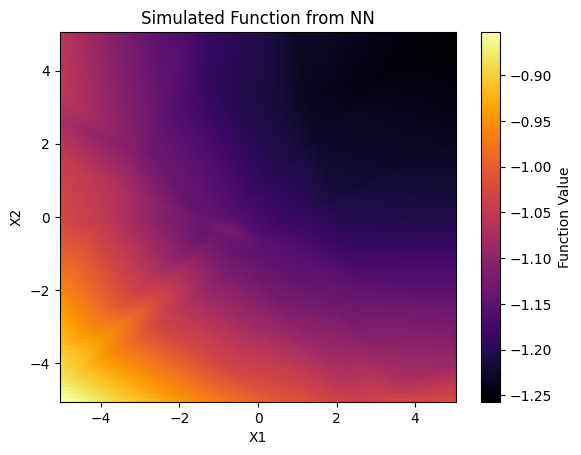

In [10]:
plot_simulated_meshgrid(X, Y, mesh_results, model='NN')

C:\Users\Pascal\AppData\Roaming\Python\Python310\site-packages\torch\functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ..\aten\src\ATen\native\TensorShape.cpp:3484.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


<Axes: title={'center': 'Ground Truth of BBOB F24 Function'}, xlabel='X', ylabel='Y'>

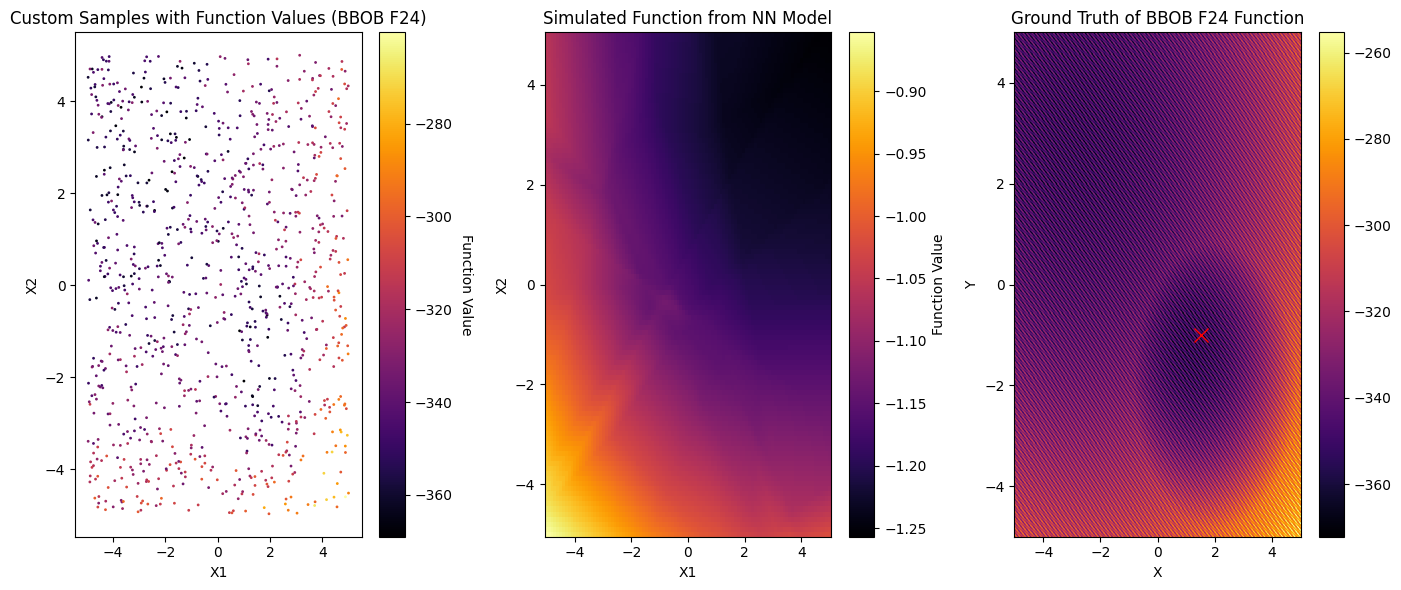

In [11]:
plot_collage(sample_f24[0], sample_f24[1], problem_f24, "BBOB F24", X, Y, mesh_results)

## Simulation with Monte Carlo Simulation


XXX until now just taken from the internet

In [12]:
# Use Gaussian Process Regression to approximate the function
kernel = C(1.0, (1e-3, 1e3)) * RBF(1.0, (1e-2, 1e2))
gpr_model = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10)

# Fit the Gaussian Process Regression model to the Monte Carlo samples
gpr_model.fit(monte_carlo_samples, monte_carlo_results)

# Generate a mesh grid for plotting the approximated function
x = np.linspace(-5.0, 5.0, 100)
y = np.linspace(-5.0, 5.0, 100)
X, Y = np.meshgrid(x, y)
mesh_samples = np.c_[X.ravel(), Y.ravel()]

# Predict function values using the GPR model on the mesh grid
mesh_results, _ = gpr_model.predict(mesh_samples, return_std=True)
mesh_results = mesh_results.reshape(X.shape)

NameError: name 'monte_carlo_samples' is not defined

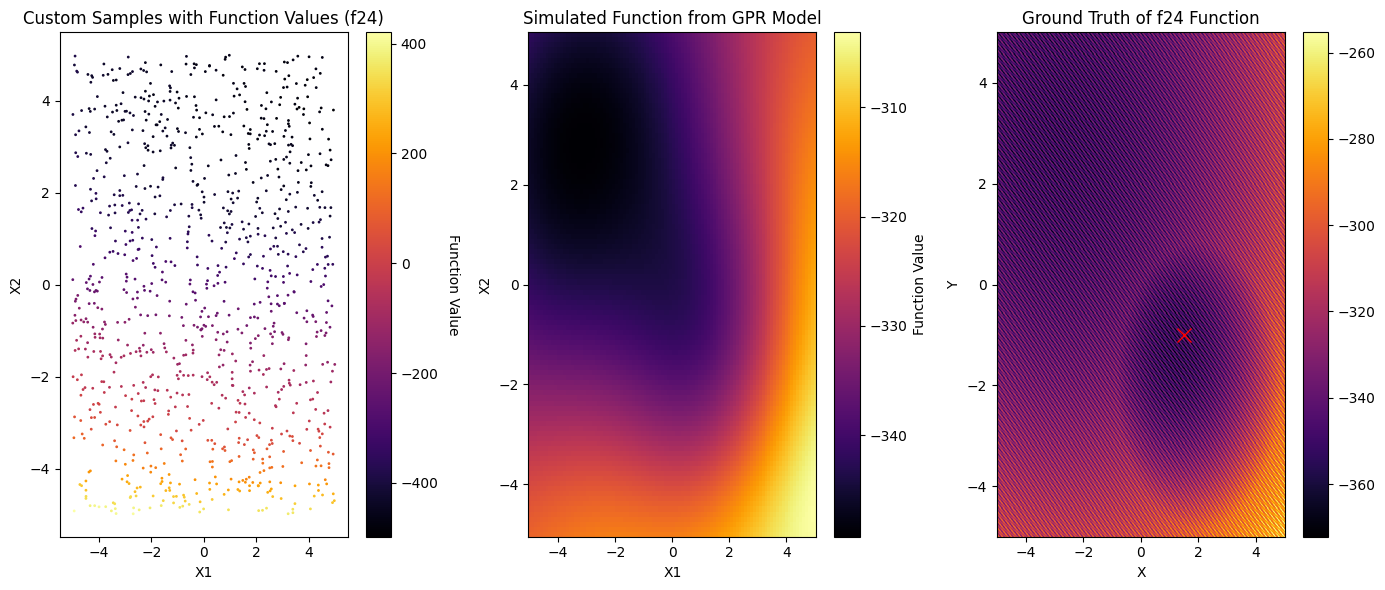

In [ ]:
# Plot the sampled points
plt.figure(figsize=(14, 6))

plt.subplot(1, 3, 1)
plot_sampled_data(monte_carlo_samples, monte_carlo_results, problem_name)


# Plot the predicted function
plt.subplot(1, 3, 2)
plot_simulated_meshgrid(X, Y, mesh_results, "GPR Model")

# Plot the ground truth function
plt.subplot(1, 3, 3)
plot_ground_truth(f_name=problem_name)

plt.tight_layout()
plt.show()

## Simulation with Support Vector Regression

In [ ]:
from sklearn.svm import SVR

In [ ]:
# simulate the function with the aboth samples and results
X_svc = samples
y_svc = results.float()
model_name = "SVR Model"

In [ ]:
# define svr model
# XXX parameters are not optimized
svr_model = SVR(kernel='sigmoid', C=1.0, epsilon=0.1)

# Fit the SVR model to the Monte Carlo samples
svr_model.fit(X_svc, y_svc)


SVR()

In [ ]:
#Generate a mesh grid for plotting the approximated function
x = np.linspace(-5.0, 5.0, 100)
y = np.linspace(-5.0, 5.0, 100)
X, Y = np.meshgrid(x, y)
mesh_samples = np.c_[X.ravel(), Y.ravel()]

# Predict function values using the SVR model on the mesh grid
mesh_results = svr_model.predict(mesh_samples)
mesh_results = mesh_results.reshape(X.shape)

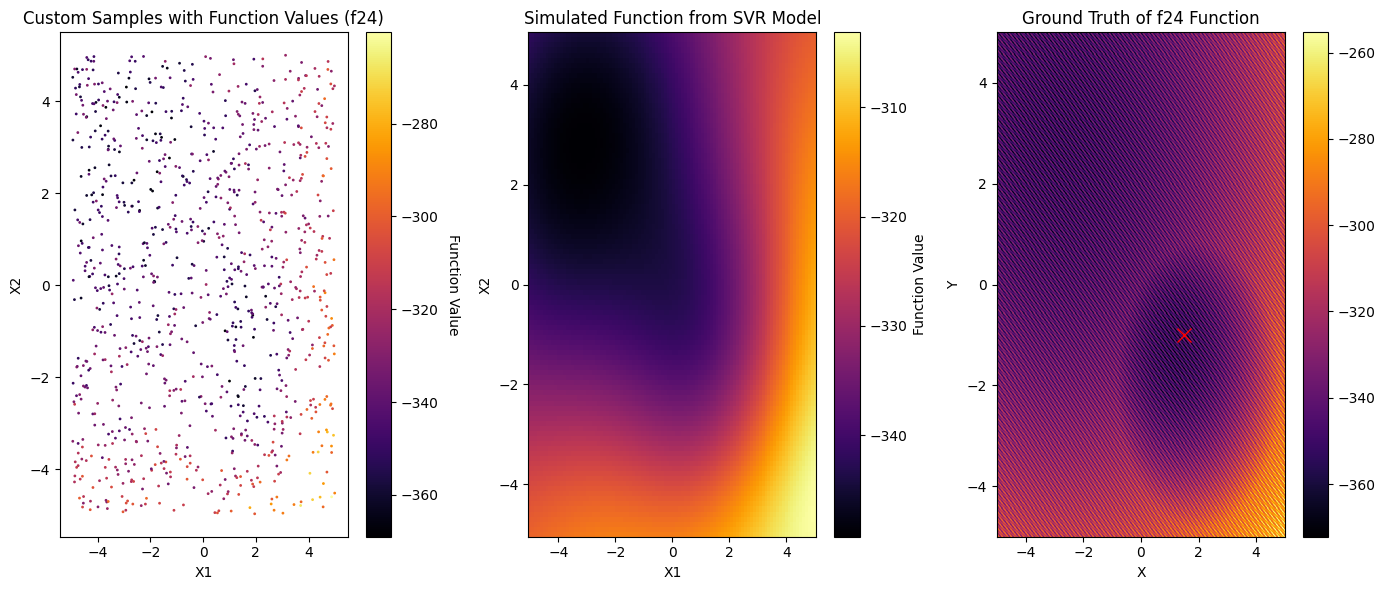

In [ ]:
# Plot the sampled points
plt.figure(figsize=(14, 6))
plt.subplot(1, 3, 1)
plot_sampled_data(X_svc, y_svc, problem_name)

# Plot the approximated function from SVR
plt.subplot(1, 3, 2)
plot_simulated_meshgrid(X, Y, mesh_results, model_name)


# Plot the ground truth function
plt.subplot(1, 3, 3)
plot_ground_truth(f_name=problem_name)


plt.tight_layout()
plt.show()